## Installations & Imports

In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import re
from wordcloud import WordCloud
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
from gensim import corpora, models
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

## Accessing Titles

In [2]:
# Define the path to OAuth2 credentials JSON file
creds_path = r'C:\Users\cathe\practical-data-science-tutorial\src\data\credentials.json'

# Define the name of Google Sheet
google_sheet_name = 'Draft-dataset'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_names = ['Health and medical sciences', 'Social sciences', 'Business, economics and management']

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

article_names = []

for specific_sheet_name in specific_sheet_names:
    # Open the Google Sheet
    sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

    # Get list of article names from the sheet
    papers = sheet.col_values(3)[1:]

    # Add all article names to a single list
    article_names.extend(papers)

c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\gspread\auth.py:63: DeprecationWarning: [Deprecated][in version 6.0.0]: client_factory will be replaced by gspread.http_client types
  warnings.warn(


In [3]:
article_names[0]

'The psychological impact of quarantine and how to reduce it: rapid review of the evidence'

In [4]:
len(article_names)

1242

## Exploration of Titles

c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


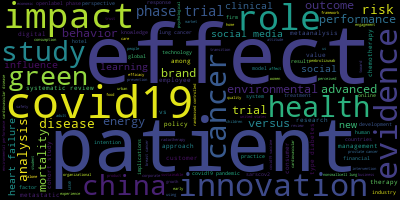

In [5]:
article_names_cleaned = np.vectorize(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))(article_names)

article_names_lower = np.vectorize(lambda x: x.lower())(article_names_cleaned)

all_titles = ','.join(list(article_names_lower))

wordcloud = WordCloud()

wordcloud.generate(all_titles)

wordcloud.to_image()

## Preprocessing Titles

In [6]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
# Define stopwords to remove
custom_stopwords = set(['the', 'a', 'of', 'in', 'an', 'covid19', 'sarscov2'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Tokenize the title (break down into words)
    words = word_tokenize(title_lower)

    # Remove stopwords
    words = [word for word in words if word not in custom_stopwords]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Map POS tags to WordNet tags for lemmatisation
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        else:
            return wordnet.VERB

    # Lemmatisation of verbs (converts all verbs that are the same to the infinitive) & removal of nouns
    lemmatised_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_words if not pos.startswith('N')]
    #lemmatised_words = [lemmatizer.lemmatize(word, pos='v') for word, pos in tagged_words]

    # Join the words back into a processed title
    processed_title = ' '.join(lemmatised_words)

    return processed_title

# Apply preprocessing to all titles
preprocessed_titles = [preprocess_title(title) for title in article_names]
preprocessed_titles[0:4]

['psychological and how to reduce it rapid',
 'global regional and national and live with for 354 and for 195 and 19902017 systematic for global 2017',
 'novel global',
 'and italy what next']

In [8]:
before_preprocessing = " ".join(article_names)
before_preprocessing = re.sub(r'[^a-zA-Z0-9\s]', '', before_preprocessing)
before_preprocessing = before_preprocessing.lower()

after_preprocessing = " ".join(preprocessed_titles)

# Function to plot word frequencies with Plotly
def plot_word_frequencies(data, title):

    # Count the occurrences of each word
    words = data.split()
    word_counts = Counter(words)

    # Order the results by word counts
    ordered_word_counts = word_counts.most_common(20)
    
    # Create a Plotly bar chart
    fig = px.bar(
        x=[word[0] for word in ordered_word_counts],
        y=[word[1] for word in ordered_word_counts],
        labels={'x': 'Words', 'y': 'Frequency'},
        title=f"Top 10 Most Frequent Words - {title}",
    )

    # Show the chart
    fig.show()

# Plot before preprocessing
plot_word_frequencies(before_preprocessing, "Before Preprocessing")

# Plot after preprocessing
plot_word_frequencies(after_preprocessing, "After Preprocessing")

In [9]:
before_preprocessing = " ".join(article_names)
before_preprocessing = re.sub(r'[^a-zA-Z0-9\s]', '', before_preprocessing)
before_preprocessing = before_preprocessing.lower()

after_preprocessing = " ".join(preprocessed_titles)

# Count the occurrences of each word
words = before_preprocessing.split()
word_counts = Counter(words)
words2 = after_preprocessing.split()
word_counts2 = Counter(words2)

# Order the results by word counts
ordered_word_counts = word_counts.most_common(30)
ordered_word_counts2 = word_counts2.most_common(30)

# Create dataframe to store words
df = pd.DataFrame(columns = ['Word', 'Count', 'Colour'])

# Add all original words to dataframe as blue
for word, count in ordered_word_counts:
    df.loc[len(df.index)] = [word, count, 'blue'] 

# Change bar colour of preprocessed words to be red
for word, count in ordered_word_counts2:
    if word in df['Word'].values:
        index_to_change = df[df['Word'] == word].index[0]
        df.at[index_to_change, 'Colour'] = 'red'

# Create a Plotly bar chart
fig = px.bar(df, x='Word', y='Count', color='Colour',
             category_orders={'Word': df['Word'].tolist()},
             title = 'Words Removed and Remaining After Preprocessing Paper Titles')

# Change labels and order words by counts not colour
legend_labels = {'blue': 'Before preprocessing', 'red': 'After preprocessing'}
fig.for_each_trace(lambda t: t.update(name=legend_labels.get(t.name, t.name)))
fig.show()

## Document-Term Matrix (DTM)

In [11]:
vectorizer = CountVectorizer()

# Fit and transform the preprocessed titles to create the DTM
dtm = vectorizer.fit_transform(preprocessed_titles)

# Get the feature names (terms) from the vectoriser
feature_names = vectorizer.get_feature_names_out()
dtm_array = dtm.toarray()

# Print the DTM and feature names
print("Document-Term Matrix (DTM):")
print(dtm_array)
print("Feature Names (Terms):")
print(feature_names)

Document-Term Matrix (DTM):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature Names (Terms):
['000' '012' '067' ... 'youth' 'zero' 'zoledronic']


## Latent Dirichlet Allocation (LDA)

### Using sklearn

In [35]:
# Number of topics
num_topics = 3

# Initialize the LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the LDA model to the DTM
lda.fit(dtm_array)

# Get the topic-word distributions
topic_word_distributions = lda.components_

# Get the document-topic distributions
document_topic_distributions = lda.transform(dtm_array)

# Print the top words for each topic
n_top_words = 5
for topic_idx, topic in enumerate(topic_word_distributions):
    top_terms_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_terms = [feature_names[i] for i in top_terms_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_terms)}")

# Print the topic distribution for each document
for doc_idx, doc_topics in enumerate(document_topic_distributions):
    print(f"Article {doc_idx + 1}: {doc_topics}")

Topic 1: and, on, with, to, or
Topic 2: and, with, systematic, for, advanced
Topic 3: and, for, from, on, social
Article 1: [0.90013509 0.04621447 0.05365044]
Article 2: [0.01965091 0.95962879 0.0207203 ]
Article 3: [0.75900562 0.12975321 0.11124116]
Article 4: [0.55842557 0.36792157 0.07365286]
Article 5: [0.84646443 0.07646837 0.0770672 ]
Article 6: [0.05256109 0.09036904 0.85706987]
Article 7: [0.58322851 0.08437894 0.33239255]
Article 8: [0.73365785 0.11120709 0.15513506]
Article 9: [0.03605329 0.91079161 0.05315509]
Article 10: [0.82062547 0.084335   0.09503953]
Article 11: [0.61706362 0.34850514 0.03443125]
Article 12: [0.23145303 0.73533268 0.03321429]
Article 13: [0.86147623 0.06889954 0.06962423]
Article 14: [0.0357257  0.92826164 0.03601266]
Article 15: [0.11155552 0.77076144 0.11768305]
Article 16: [0.85137552 0.0777376  0.07088688]
Article 17: [0.0319258  0.83678762 0.13128659]
Article 18: [0.64429897 0.18882999 0.16687104]
Article 19: [0.88512893 0.05431643 0.06055464]
Art

### Using genism

In [12]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Define stopwords to remove
custom_stopwords = set(['the', 'a', 'of', 'in', 'an', 'covid19', 'sarscov2'])
custom_keep_nouns = set(['impact', 'impacts', 'effect', 'effects', 'cause', 'causes', 'influence', 
                         'influences', 'consequence', 'consequences', 'result', 'results', 'outcome', 
                         'outcomes', 'origin', 'origins', 'source', 'sources', 'reason', 'reasons', 
                         'stimulus', 'stimuli', 'motivation', 'motivations'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Break down into individual words
    words = word_tokenize(title_lower)

    # Remove stopwords
    words = [word for word in words if word not in custom_stopwords]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Map POS tags to WordNet tags for lemmatisation
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        else:
            return wordnet.VERB
        
    lemmatised_words = []

    # Lemmatisation of verbs (converts all verbs that are the same to the infinitive) & removal of nouns (except causal nouns)
    for word, pos in tagged_words:
        if word in custom_keep_nouns or not pos.startswith('N'):
            lemmatised_words.append(lemmatizer.lemmatize(word, get_wordnet_pos(pos)))

    return lemmatised_words

# Apply preprocessing to all titles
preprocessed_titles = [preprocess_title(title) for title in article_names]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
# Reduce paper title lists to single strings
before_preprocessing = " ".join(article_names)
words = before_preprocessing.split()
words2 = [word for sublist in preprocessed_titles for word in sublist]

# Count occurences of each word
word_counts = Counter(words)
word_counts2 = Counter(words2)

# Order the results by word counts
ordered_word_counts = word_counts.most_common(30)
ordered_word_counts2 = word_counts2.most_common(30)

# Create dataframe to store words
df = pd.DataFrame(columns = ['Word', 'Count', 'Colour'])

# Add all original words to dataframe as blue
for word, count in ordered_word_counts:
    df.loc[len(df.index)] = [word, count, 'blue'] 

# Change bar colour of preprocessed words to be red
for word, count in ordered_word_counts2:
    if word in df['Word'].values:
        index_to_change = df[df['Word'] == word].index[0]
        df.at[index_to_change, 'Colour'] = 'red'

# Create a Plotly bar chart
fig = px.bar(df, x='Word', y='Count', color='Colour',
             category_orders={'Word': df['Word'].tolist()},
             title = 'Words Removed and Remaining After Preprocessing Paper Titles')

# Change labels and order words by counts not colour
legend_labels = {'blue': 'Before preprocessing', 'red': 'After preprocessing'}
fig.for_each_trace(lambda t: t.update(name=legend_labels.get(t.name, t.name)))
fig.show()

In [14]:
# Create a dictionary of terms in the preprocessed titles
id2word = corpora.Dictionary(preprocessed_titles)

# Convert the preprocessed titles into a bag-of-words representation
# where each document is represented as a list of (term_id, term_frequency) pairs
corpus = [id2word.doc2bow(word) for word in preprocessed_titles]

In [15]:
# Flatten the list of lists into a list of strings
flattened_titles = [' '.join(words) for words in preprocessed_titles]

# Convert the corpus to TF-IDF representation
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(flattened_titles)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, init='random')
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for the scatter plot
scatter_df = pd.DataFrame(X_tsne, columns=['X', 'Y'])

# Create the scatter plot
fig = px.scatter(scatter_df, x='X', y='Y', title='t-SNE Scatter Plot of Paper Title Similarity')

# Show the plot
fig.show()

In [16]:
# Flatten the list of lists into a list of strings
flattened_titles = [' '.join(words) for words in preprocessed_titles]

# Convert the corpus to TF-IDF representation
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(flattened_titles)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=3, random_state=42, init='random')
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for the scatter plot
scatter_df = pd.DataFrame(X_tsne, columns=['X', 'Y', 'Z'])

# Create the scatter plot
fig = px.scatter_3d(scatter_df, x='X', y='Y', z='Z', title='t-SNE Scatter Plot of Paper Title Similarity')

# Show the plot
fig.show()

In [17]:
# Define the number of topics you want the LDA model to discover
num_topics = 5

# Initialize and train an LDA model using multicore processing for efficiency
lda_model = models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Apply the trained LDA model to the corpus to get topic distributions for each document
doc_lda = lda_model[corpus]

# Print the discovered topics along with their top terms
lda_model.print_topics()

[(0,
  '0.045*"for" + 0.035*"on" + 0.026*"and" + 0.017*"effect" + 0.015*"to" + 0.012*"as" + 0.010*"impact" + 0.009*"metastatic" + 0.009*"randomise" + 0.008*"during"'),
 (1,
  '0.091*"and" + 0.035*"to" + 0.029*"with" + 0.015*"effect" + 0.014*"social" + 0.013*"from" + 0.012*"green" + 0.012*"for" + 0.010*"on" + 0.010*"be"'),
 (2,
  '0.138*"and" + 0.039*"on" + 0.030*"effect" + 0.029*"with" + 0.027*"for" + 0.013*"social" + 0.011*"from" + 0.010*"to" + 0.007*"be" + 0.007*"impact"'),
 (3,
  '0.050*"with" + 0.033*"and" + 0.020*"for" + 0.018*"to" + 0.014*"from" + 0.014*"or" + 0.012*"on" + 0.011*"do" + 0.010*"plus" + 0.009*"effect"'),
 (4,
  '0.091*"and" + 0.037*"on" + 0.030*"impact" + 0.026*"from" + 0.011*"with" + 0.009*"for" + 0.009*"effect" + 0.009*"to" + 0.009*"environmental" + 0.008*"after"')]

In [18]:
# Enable the use of pyLDAvis within a Jupyter Notebook
pyLDAvis.enable_notebook()

# Prepare the data for visualisation
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.056575 -0.013191       1        1  34.861282
1      0.013885 -0.077209       2        1  22.200430
3     -0.104271 -0.021634       3        1  16.002505
4      0.060346  0.029183       4        1  15.730012
0     -0.026536  0.082851       5        1  11.205771, topic_info=               Term        Freq       Total Category  logprob  loglift
12              for  153.000000  153.000000  Default  30.0000  30.0000
2            impact   64.000000   64.000000  Default  29.0000  29.0000
40               on  193.000000  193.000000  Default  28.0000  28.0000
18             with  190.000000  190.000000  Default  27.0000  27.0000
0               and  641.000000  641.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
18             with    4.716377  190.408312   Topic5  -5.1241  -1.5094
1170      financial    3.110712   22.290663   Topic5  -5.5403   0.2194
1               how    3.097907   30.121529   Topic5  -5.5444  -0.0858
539   environmental    3.130620   41.261561   Topic5  -5.5339  -0.3900
46               or    3.096711   41.450208   Topic5  -5.5448  -0.4054

[382 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
732       5  0.656651    012
723       3  0.631223    067
785       4  0.638990   0902
452       1  0.316103      1
452       3  0.210735      1
...     ...       ...    ...
18        3  0.299357   with
18        4  0.063022   with
18        5  0.026259   with
1029      1  0.278650  young
1029      2  0.696626  young

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



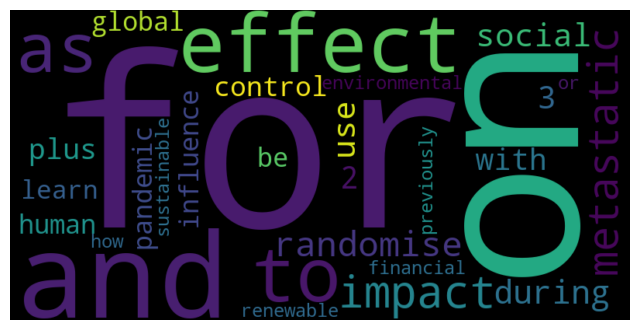

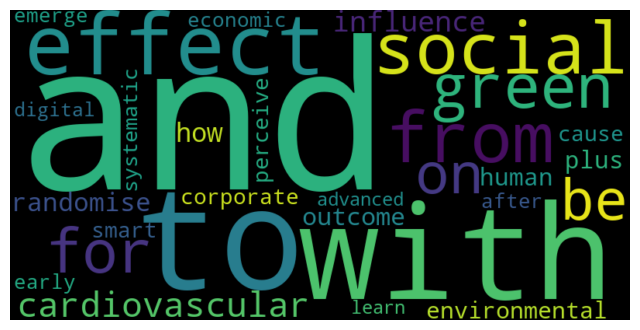

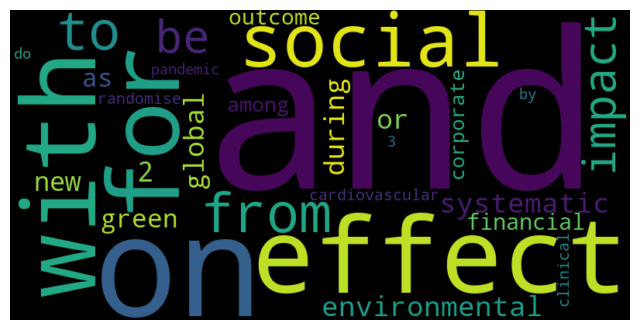

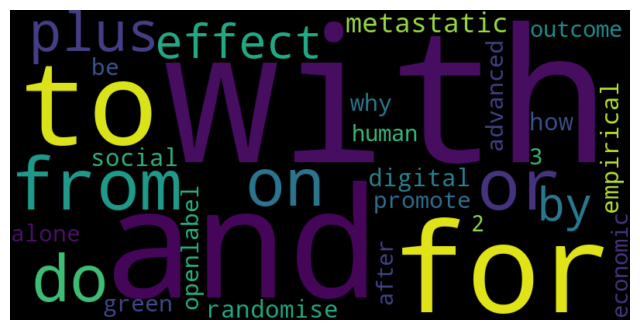

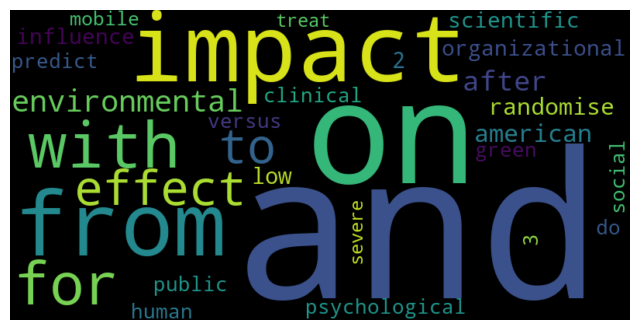

In [21]:
def generate_wordclouds(lda_model, num_topics):
    # Initialise WordCloud object
    wordcloud = WordCloud(width=800, height=400)

    # Generate word clouds for each topic
    for topic_id in range(num_topics):
        plt.figure(figsize=(8, 6))
        topic_words = dict(lda_model.show_topic(topic_id, topn=30))
        wordcloud.generate_from_frequencies(topic_words)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

generate_wordclouds(lda_model, num_topics=5)